# CNTK入门
原文来自于微软的CNTK_101_LogisticRegression

对于一下numpy和cntk的函数，这里会在使用前给出函数的功能和使用方法。

In [1]:
# 导入所需的依赖库
from __future__ import print_function
import numpy as np
import sys
import os

import cntk as C

## 定义数据输入和输出
* 输入的数据为两个feature，分别为age和tumor size.
* 输出为两个类别的标签，良性或恶性

In [2]:
# 定义网络的输入和输出
input_dim = 2
num_output_classes = 2

## 生成模拟数据集
根据已有的经验来说，age和tumor size越小，肿瘤为恶性的可能就越小。

所以在此，我们根据这一已有经验来生成模拟数据集。

### numpy数据维度
size(tuple)为维度从外层到内层依次镶嵌

In [3]:
np.random.randint(low=0, high=5, size=(5, 3, 2))

array([[[1, 4],
        [4, 1],
        [4, 0]],

       [[2, 2],
        [4, 0],
        [1, 2]],

       [[2, 1],
        [3, 2],
        [3, 4]],

       [[4, 4],
        [2, 1],
        [0, 0]],

       [[1, 4],
        [3, 1],
        [3, 4]]])

### numpy hstack
`numpy.hstack(tuple)`

水平拼接arrays
>Stack arrays in sequence horizontally (column wise).

In [4]:
a = np.array([[1],[2],[3],[4],[5] ], dtype=np.int)
b = np.array([[6],[7],[8],[9],[10]], dtype=np.int)

np.hstack([a, b])

array([[ 1,  6],
       [ 2,  7],
       [ 3,  8],
       [ 4,  9],
       [ 5, 10]])

In [5]:
# 设置随机函数的种子，确保所产生的数据集一致
np.random.seed(0)

# 定义一个生成数据集的辅助函数
def generate_random_data_sample(sample_size, feature_dim, num_classes):
    # 随机生成标签
    Y = np.random.randint(low=0, high=num_classes, size=(sample_size, 1))
    
    # 生成与标签相符合的数据
    # 此处`*`为元素乘法
    X = (np.random.randn(sample_size, feature_dim)+3) * (Y+1)
    # 默认元素类型为double，转化为float32与CNTK的输入匹配
    X = X.astype(np.float32)
    
    # 将类型 0转化为向量 "1 0 0",
    # 将类型 1转化为向量 "0 1 0", ...
    class_ind = [Y == class_number for class_number in range(num_classes)]
    Y = np.asarray(np.hstack(class_ind), dtype=np.float32)
    
    return X, Y

## 绘制数据集样例
同时，展示如何在Jupyter Notebook中绘图

In [6]:
# 设置用于绘图的样本数
# 获取这些样本的特征与标签
mysamplesize = 32
features, labels = generate_random_data_sample(
    mysamplesize, input_dim, num_output_classes)

使用**%matplotlib inline**

在Jupyter Notebook中，将数据用可视化形式表示

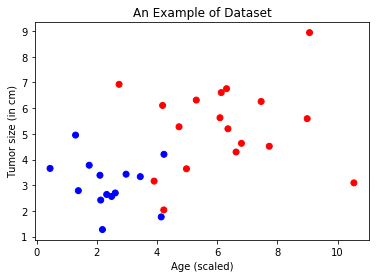

In [7]:
# 绘制数据
import matplotlib.pyplot as plt
%matplotlib inline

# 设置不同标签的颜色
# 此处若第一位为0， 则表示[0, 1]为恶性，用红色表示
colors = ['r' if label == 0 else 'b' for label in labels[:, 0]]

# 分别用两个特征作为X，Y轴
plt.scatter(features[:, 0], features[:, 1], c=colors)
plt.xlabel('Age (scaled)')
plt.ylabel('Tumor size (in cm)')
plt.title('An Example of Dataset')
plt.show()

## 创建模型

### cntk times
`C.times()`输出为两个矩阵的乘积。
>`C.times(input_var, weight_param)`等同`input_var @ weight_param`。

In [8]:
# 定义输入值——特征
feature = C.input_variable(input_dim, np.float32)
# 定义输入值——标签
label = C.input_variable(num_output_classes, np.float32)

# 定义一个字典用于储存模型参数
# 用于文末绘制回归线
mydict = {}

# 定义一个线性层
def linear_layer(input_var, output_dim):
    
    # 获取输入维度
    input_dim = input_var.shape[0]
    # 定义权重参数 shape: (2,)
    weight_param = C.parameter(shape=(input_dim, output_dim))
    # 定义偏置参数 shape: (2, 2)
    bias_param = C.parameter(shape=(output_dim))
    
    # 保存已定义的参数
    mydict['w'], mydict['b'] = weight_param, bias_param
    
    # 矩阵乘积加上一个偏置参数
    # (2,) @ (2, 2) + (2,)
    return C.times(input_var, weight_param) + bias_param

# 输出维度与输出的分类种类相同
output_dim = num_output_classes
# 创建一个线性层
z = linear_layer(feature, output_dim)

### 损耗函数
[`Cross-entropy`][] is a popular loss function. It is defined as:

$$ H(p) = - \sum_{j=1}^{| \textbf y |} y_j \log (p_j) $$  
where $p$ is our predicted probability from `softmax` function and $y$ is the ground-truth label, provided with the training data. In the two-class example, the `label` variable has two dimensions (equal to the `num_output_classes` or $| \textbf y |$). Generally speaking, the label variable will have $| \textbf y |$ elements with 0 everywhere except at the index of the true class of the data point, where it will be 1.  Understanding the [details][] of the cross-entropy function is highly recommended.

[`cross-entropy`]: http://cntk.ai/pythondocs/cntk.ops.html#cntk.ops.cross_entropy_with_softmax
[details]: http://colah.github.io/posts/2015-09-Visual-Information/

In [9]:
# 定义损耗函数
# z为我们所定义的模型
# label为我们所要预测的结果
loss = C.cross_entropy_with_softmax(z, label)
# 定义评价函数，用于计算错误率
eval_error = C.classification_error(z, label)

### 配置Trainer参数
* minibatch为一个适当大小的总样本集的子集。
* learning_rate为每一次迭代对模型参数的影响因子。

原文介绍如下：
### minibatch
An intermediate ground is to load a small set of observations into the model and use an average of the loss or error from that set to update the model parameters. This subset is called a minibatch.


### learning_rate
For now, we can think of it as a scaling factor that modulates how much we change the parameters in any iteration.

In [10]:
# 定义Trainer所需参数
# 学习速率
learning_rate = 0.5
# 学习计划
lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)
# 使用随机梯度下降的方法学习
learner = C.sgd(z.parameters, lr_schedule)
# 创建训练器
trainer = C.Trainer(z, (loss, eval_error), [learner])

In [11]:
# 初始化训练参数
# 每一minibatch的样本数
minibatch_size = 25
# 样本总数
num_sample_to_train = 20000
# minibatch的总数
num_minibatches_to_train = int(num_sample_to_train / minibatch_size)

In [12]:
# 定义辅助函数
# 用于计算算数移动平均数
# 移动平均法常用于平滑滤波
# 能够平滑掉突然的波动对预测结果的影响
def moving_average(a, w=10):
    if len(a) < w:
        return a[:]
    return [val if idx < w else sum(a[(idx-w):idx])/w 
            for idx, val in enumerate(a)]

# 用于输出训练过程中的信息
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss, eval_error = "NA", "NA"
    
    # 若达到指定的输出项，则计算并输出
    if mb % frequency == 0:
        # 到当前minibatch为止的平均损耗
        training_loss = trainer.previous_minibatch_loss_average
        # 到当前迷你batch为止的平均错误率
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose:
            print("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}".
                  format(mb, training_loss, eval_error))
            
    return mb, training_loss, eval_error

### numpy cumsum
计算累加和

In [13]:
np.cumsum(np.arange(10))

array([ 0,  1,  3,  6, 10, 15, 21, 28, 36, 45], dtype=int32)

In [14]:
# 可以使用np.cumsum来定义更高效的函数
def moving_average_np(a, w=10):
    if len(a) < w:
        return a[:]
    ret = np.cumsum(a, np.float32)
    return [val if idx < w else (ret[idx]-ret[idx-w])/w 
            for idx, val in enumerate(a)]

In [15]:
from collections import defaultdict

# 输出训练信息的频率
training_progress_out_freq = 50
# 用于画图的数据
plotdata = defaultdict(list)

for i in range(0, num_minibatches_to_train):
    # 生成样本数据
    features, labels = generate_random_data_sample(
        minibatch_size, input_dim, num_output_classes)
    
    # 训练模型
    trainer.train_minibatch({feature: features, label: labels})
    batchsize, loss, error = print_training_progress(
        trainer, i, training_progress_out_freq)
    
    if not (loss == 'NA' or error == 'NA'):
        plotdata['batchsize'].append(batchsize)
        plotdata['loss'].append(loss)
        plotdata['error'].append(error)

Minibatch: 0, Loss: 0.6931, Error: 0.32
Minibatch: 50, Loss: 4.4290, Error: 0.36
Minibatch: 100, Loss: 0.4585, Error: 0.16
Minibatch: 150, Loss: 0.7228, Error: 0.32
Minibatch: 200, Loss: 0.1290, Error: 0.08
Minibatch: 250, Loss: 0.1321, Error: 0.08
Minibatch: 300, Loss: 0.1012, Error: 0.04
Minibatch: 350, Loss: 0.1076, Error: 0.04
Minibatch: 400, Loss: 0.3087, Error: 0.08
Minibatch: 450, Loss: 0.3219, Error: 0.12
Minibatch: 500, Loss: 0.4076, Error: 0.20
Minibatch: 550, Loss: 0.6784, Error: 0.24
Minibatch: 600, Loss: 0.2988, Error: 0.12
Minibatch: 650, Loss: 0.1676, Error: 0.12
Minibatch: 700, Loss: 0.2772, Error: 0.12
Minibatch: 750, Loss: 0.2309, Error: 0.04


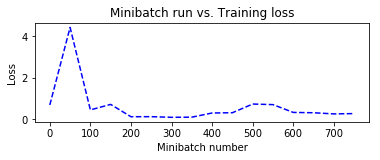

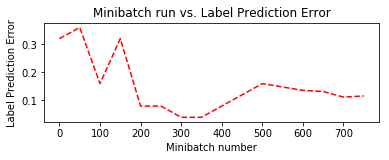

In [16]:
# 平滑滤波
plotdata['avgloss'] = moving_average(plotdata['loss'])
plotdata['avgerror'] = moving_average(plotdata['error'])

import matplotlib.pyplot as plt

plt.figure(1)
# 211分别表示
# 2--两幅图
# 1--第1列
# 1--第1行
plt.subplot(211)
plt.plot(plotdata['batchsize'], plotdata['avgloss'], 'b--')
plt.xlabel('Minibatch number')
plt.ylabel('Loss')
plt.title('Minibatch run vs. Training loss')

plt.show()

plt.subplot(212)
plt.plot(plotdata['batchsize'], plotdata['avgerror'], 'r--')
plt.xlabel('Minibatch number')
plt.ylabel('Label Prediction Error')
plt.title('Minibatch run vs. Label Prediction Error')
plt.show()

### 测试模型

In [17]:
# 生成测试样本数据
test_minibatch_size = 25
features, labels = generate_random_data_sample(
    test_minibatch_size, input_dim, num_output_classes)

# 测试模型
trainer.test_minibatch({feature: features, label: labels})

0.12

In [18]:
out = C.softmax(z)
result = out.eval({feature: features})

#### numpy argmax
`np.argmax(a, axis=None, out=None)`

返回沿axis轴最大值的索引

In [19]:
print("Label    :", [np.argmax(label) for label in labels])
print("Predicted:", [np.argmax(x) for x in result])

Label    : [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1]
Predicted: [1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1]


[ 7.99141502 -7.99141407]


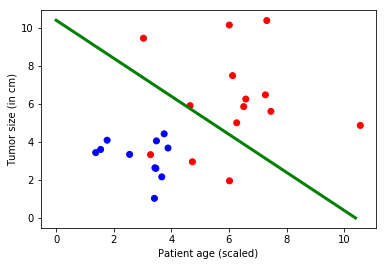

In [20]:
# 模型参数
print(mydict['b'].value)

bias_vector   = mydict['b'].value
weight_matrix = mydict['w'].value

# 绘制数据
import matplotlib.pyplot as plt

# 设置良性为蓝色，恶性为红色
colors = ['r' if label == 0 else 'b' for label in labels[:,0]]
# 绘制点
plt.scatter(features[:,0], features[:,1], c=colors)
# 绘制线
plt.plot([0, bias_vector[0]/weight_matrix[0][1]], 
         [ bias_vector[1]/weight_matrix[0][0], 0], c = 'g', lw = 3)
plt.xlabel("Patient age (scaled)")
plt.ylabel("Tumor size (in cm)")
plt.show()

### 绘制错误率

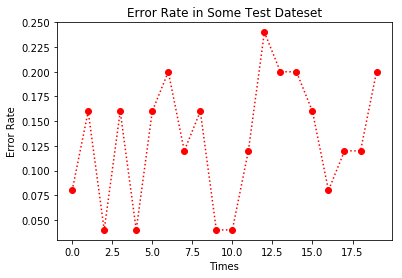

In [21]:
test_minibatch_size = 25

error_rate = []
for i in range(20):
    # 生成测试数据
    features, labels = generate_random_data_sample(
        test_minibatch_size, input_dim, num_output_classes)
    # 添加错误率
    error_rate.append(
        trainer.test_minibatch({feature: features, label: labels}))

plt.plot(error_rate, 'ro:')
plt.xlabel('Times')
plt.ylabel('Error Rate')
plt.title('Error Rate in Some Test Dateset')
plt.show()